In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

In [3]:
#Load dataset
df_train = pd.read_json("D:/StatoilC-CORE Iceberg Classifier Challenge/train.json/train.json")
df_train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [4]:
# Replace Nan value
df_train.inc_angle.replace({"na":np.nan}, inplace=True)
# Drop the rows that has NaN value for inc_angle
df_train.drop(df_train[df_train["inc_angle"].isnull()].index, inplace=True)

In [5]:
def prepare_data(df):
    X_band_1 = []
    X_band_2 = []
    
    for band in df["band_1"]:
        #Convert to float32
        band_1 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_1 = band_1.reshape(75,75)
        X_band_1.append(band_1)
        
    for band in df["band_2"]:
         #Convert to float32
        band_2 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_2 = band_2.reshape(75,75)
        X_band_2.append(band_2)
        
    #Convert list to numpy array
    X_band_1 = np.array(X_band_1)
    X_band_2 = np.array(X_band_2)
    
    # Rescale
    X_band_1 = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
    X_band_2 = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
    
    #Concatenate band_1 and band_2 to create X for training (or test)
    X = np.concatenate([X_band_1[:, :, :, np.newaxis], 
                        X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], 
                        axis=-1)
    
    Y = np.array(df["is_iceberg"])
    
    return X, Y

In [6]:
X, Y = prepare_data(df_train)

print("X shape is:{}".format(X.shape))
print("Y shape is:{}".format(Y.shape))

X shape is:(1471, 75, 75, 3)
Y shape is:(1471,)
X_inc_angle shape is:(1471,)


# Transfer learning using ResNet50

In [7]:
SIZE = 75

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [8]:
# Normalize and reshape
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train = X_train / 255
X_test = X_test / 255

In [22]:
# One hot encoding
y_train_one_hot = to_categorical(Y_train)
y_test_one_hot = to_categorical(Y_test)

In [23]:
resnet50_model = ResNet50(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))
resnet50_model.summary()

C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2647s 28us/step


In [25]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 38, 38, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [27]:
# Make Loaded layers as non-trainable
for layer in resnet50_model.layers:
    layer.trainable = False
    
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 38, 38, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [63]:
# Set the flat layers
flat_layer = Flatten()(resnet50_model.layers[-1].output)
dense_layer = Dense(75, activation='relu', kernel_initializer='he_uniform')(flat_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Set a new model
newmodel = Model(inputs=resnet50_model.inputs, outputs=output_layer) 

# compile the new model
optimizer = SGD(lr=0.01, momentum=0.9)
newmodel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

newmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 38, 38, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [31]:
# Fit the model and check the accuracy
transfer_model = newmodel.fit(X_train, Y_train, batch_size=32, epochs=5, verbose=1, validation_data=(X_test, Y_test))
loss, acc = newmodel.evaluate(X_test, Y_test, verbose=1)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

Train on 1323 samples, validate on 148 samples
Epoch 1/5
1323/1323 [==============================] - 245s 185ms/step - loss: 0.5652 - accuracy: 0.7347 - val_loss: 0.6913 - val_accuracy: 0.5473
Epoch 2/5
1323/1323 [==============================] - 242s 183ms/step - loss: 0.3163 - accuracy: 0.8677 - val_loss: 0.7291 - val_accuracy: 0.5473
Epoch 3/5
1323/1323 [==============================] - 246s 186ms/step - loss: 0.1918 - accuracy: 0.9146 - val_loss: 0.9805 - val_accuracy: 0.5473
Epoch 4/5
1323/1323 [==============================] - 253s 191ms/step - loss: 0.1188 - accuracy: 0.9524 - val_loss: 0.9719 - val_accuracy: 0.5473
Epoch 5/5
148/148 [==============================] - 31s 212ms/step

Testing loss: 1.2343651539570577, acc: 0.5472972989082336



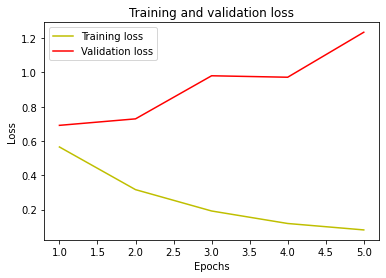

In [32]:
loss = transfer_model.history['loss']
val_loss = transfer_model.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

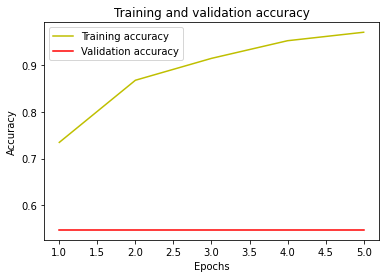

In [33]:
acc = transfer_model.history['accuracy']
val_acc = transfer_model.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
# Save model using pickle
with open(".../transfer_learning_resnet50", "wb") as file:
    pickle.dump(transfer_model, file)

In [51]:
# prediction the newmodel
y_pred = newmodel.predict(X_test)

In [64]:
# Evaluate model
test_loss, test_acc = newmodel.evaluate(X_test, Y_test, verbose=0)
print("Test Score = ", test_loss)
print("Test Accuracy = ", test_acc)

Test Score =  0.7222835405452831
Test Accuracy =  0.45270270109176636
